In [3]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt

In [4]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_dataset = valid_dataset[:5000]
  valid_labels = save['valid_labels']
  valid_labels = valid_labels[:5000]
  test_dataset = save['test_dataset']
  test_dataset = test_dataset[:5000]
  test_labels = save['test_labels']
  test_labels = test_labels[:5000]
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (5000, 28, 28) (5000,)
Test set (5000, 28, 28) (5000,)


Reformat into a TensorFlow-friendly shape:
* convolutions need the image data formatted as a cube (width by height by #channels)
* labels as float 1-hot encodings.

In [5]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (5000, 28, 28, 1) (5000, 10)
Test set (5000, 28, 28, 1) (5000, 10)


In [6]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [44]:
batch_size = 64
patch_size = 5
depth = 32
num_hidden = 256

graph = tf.Graph()
with graph.as_default():
  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

  # Model.
  # four layer convolutional NN, {relu[(input -> conv)+bias]->Hidden}*2 --> linear*2
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])

    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases

  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
     tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [45]:
num_steps = 1001
#
with tf.Session(graph=graph,config=tf.ConfigProto(allow_soft_placement=True,log_device_placement=True)) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 6.585915
Minibatch accuracy: 9.4%
Validation accuracy: 9.5%
Minibatch loss at step 50: 0.897148
Minibatch accuracy: 76.6%
Validation accuracy: 74.8%
Minibatch loss at step 100: 0.795110
Minibatch accuracy: 79.7%
Validation accuracy: 77.7%
Minibatch loss at step 150: 0.792732
Minibatch accuracy: 81.2%
Validation accuracy: 79.0%
Minibatch loss at step 200: 0.623030
Minibatch accuracy: 81.2%
Validation accuracy: 81.3%
Minibatch loss at step 250: 0.674460
Minibatch accuracy: 81.2%
Validation accuracy: 81.2%
Minibatch loss at step 300: 0.749752
Minibatch accuracy: 79.7%
Validation accuracy: 80.7%
Minibatch loss at step 350: 0.481340
Minibatch accuracy: 84.4%
Validation accuracy: 82.2%
Minibatch loss at step 400: 0.670745
Minibatch accuracy: 79.7%
Validation accuracy: 82.6%
Minibatch loss at step 450: 0.495346
Minibatch accuracy: 90.6%
Validation accuracy: 82.6%
Minibatch loss at step 500: 0.271155
Minibatch accuracy: 93.8%
Validation accuracy: 82.6%
Min

# Problem1
The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (nn.max_pool()) of stride 2 and kernel size 2

In [24]:
batch_size = 64
patch_size = 5
depth = 128
num_hidden = 512
lamba = 5e-3
SEED =66478


graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  # four layer convolutional NN, {relu[(input -> conv)+bias]->Hidden}*2 --> linear*2
  def model(data,train=False):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    pooling = tf.nn.max_pool(hidden,[1,2,2,1],[1,2,2,1],padding='VALID')
    conv = tf.nn.conv2d(pooling, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    pooling = tf.nn.max_pool(hidden,[1,2,2,1],[1,2,2,1],padding='VALID')
    shape = pooling.get_shape().as_list()
    reshape = tf.reshape(pooling, [shape[0], shape[1] * shape[2] * shape[3]])
    if train:
        reshape = tf.nn.dropout(reshape,0.5)
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    if train:
        hidden = tf.nn.dropout(hidden,0.5,seed=SEED)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
    
  
  L2 = lamba*tf.nn.l2_loss(layer1_weights)+lamba*tf.nn.l2_loss(layer1_biases)+ lamba*tf.nn.l2_loss(layer2_weights)+lamba*tf.nn.l2_loss(layer2_biases)+ lamba*tf.nn.l2_loss(layer3_weights)+lamba*tf.nn.l2_loss(layer3_biases)+ lamba*tf.nn.l2_loss(layer4_weights)+lamba*tf.nn.l2_loss(layer4_biases)
    
  #### Rate decay
  global_step = tf.Variable(0)  # count the number of steps taken.
  learning_rate = tf.train.exponential_decay(0.05, global_step,100000,0.95,staircase=True)
    
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)+L2)
  
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [25]:
num_steps = 3001
valid_error = []
train_error = []
with tf.Session(graph=graph,config=tf.ConfigProto(allow_soft_placement=True,log_device_placement=True)) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      train_accuracy = accuracy(predictions, batch_labels)
      print('Minibatch accuracy: %.1f%%' % train_accuracy)
      valid_accuracy =accuracy(valid_prediction.eval(), valid_labels)
      print('Validation accuracy: %.1f%%' % valid_accuracy)
      train_error.append(100-train_accuracy)
      valid_error.append(100-valid_accuracy)
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 92.209244
Minibatch accuracy: 14.1%
Validation accuracy: 9.5%
Minibatch loss at step 50: 74.787781
Minibatch accuracy: 75.0%
Validation accuracy: 66.4%
Minibatch loss at step 100: 72.926582
Minibatch accuracy: 75.0%
Validation accuracy: 75.5%
Minibatch loss at step 150: 70.949699
Minibatch accuracy: 79.7%
Validation accuracy: 78.3%
Minibatch loss at step 200: 69.109177
Minibatch accuracy: 79.7%
Validation accuracy: 80.2%
Minibatch loss at step 250: 67.495178
Minibatch accuracy: 76.6%
Validation accuracy: 80.7%
Minibatch loss at step 300: 65.750160
Minibatch accuracy: 76.6%
Validation accuracy: 80.6%
Minibatch loss at step 350: 63.932228
Minibatch accuracy: 87.5%
Validation accuracy: 82.0%
Minibatch loss at step 400: 62.727989
Minibatch accuracy: 78.1%
Validation accuracy: 81.7%
Minibatch loss at step 450: 60.861019
Minibatch accuracy: 85.9%
Validation accuracy: 82.6%
Minibatch loss at step 500: 59.159462
Minibatch accuracy: 93.8%
Validation accurac

In [26]:
%matplotlib inline

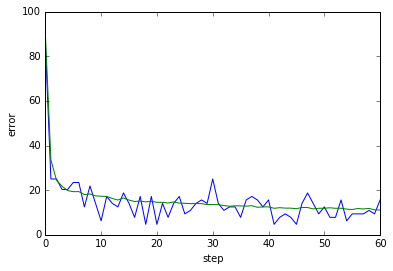

In [27]:
size = len(valid_error)
step = np.arange(size)
plt.plot(step,train_error)
plt.plot(step,valid_error)
plt.xlabel("step")
plt.ylabel("error")